In [ ]:
# Importing Libraries

import numpy as np
import torch 
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [ ]:
import numpy as np

"""
What does the .item() means in the pytorch

Explanation: .item() is used to get the particular value from the tensor.
"""

# ================================================================== #
#                       Zero Dimenion Tensor                         #
# ================================================================== #

t0 = torch.tensor(5.0)
print(t0)
print(type(t0))

# to get the value of tensor as int/float use .item()
print(t0.item())
print(type(t0.item()))

# ================================================================== #
#                        One Dimenion Tensor                         #
# ================================================================== #

t1 = torch.tensor([1,2,3,4])
print(t1)
# How to get the particular value from 1D tensor
print(t1[2].item())

# ================================================================== #
#                        Two Dimenion Tensor                         #
# ================================================================== #

t2 = torch.tensor([[1,2],[3,4]])
print(t2[1][1].item())
print((t2.shape))

first_col = t2[:][1].data
print("First col is: ", first_col)


# ================================================================== #
#                      Tensor to numpy conversion                    #
# ================================================================== #

t2_np = t2.numpy()
print(t2_np.shape)


In [ ]:
# Downloading the training data from the MNIST class

from torchvision.datasets import MNIST

dataset = MNIST(root= 'data/', train=True, download= True)
print(len(dataset))

In [ ]:
# Downloading the testing data from the MNIST class

from torchvision.datasets import MNIST

test_dataset = MNIST(root= 'data/', train=False, download= True)
print(len(test_dataset))

In [ ]:
# transform the data from PIL images into the torch Tensor 

import torchvision.transforms as transforms

dataset = MNIST(root='data/', download = True, transform=transforms.ToTensor())

In [ ]:
"""

Data preparation step:
 - training data: used to train the model
 - validation data: used to evaluate the model during training, adjusting the hyperparameters( learning rate, momentum etc)
 - test data : used to compare the different models / approaches 

"""

# random split the data into training and validation part

from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
print(len(train_ds), len(val_ds))

In [ ]:

"""
Data loader is used to load the data into different batches of fixed batch_size

Reason: Data has been divided into batches so that computational load would be low during model training.
Shuffling helps to introduce the randomization which speeds up the training process

"""
from torch.utils.data import DataLoader

batch_size = 128

train_batch = DataLoader(train_ds, batch_size= batch_size, shuffle= True)
val_batch = DataLoader(val_ds, batch_size= batch_size, shuffle=True)


In [ ]:
# Logistic Regression Model creation without class
import torch.nn as nn 

image, label = train_ds[0]
print("Image shape: ", image.shape)
input = 28*28*1
output_classes = 10

model = nn.Linear(in_features= input, out_features= output_classes)
print(model)


In [ ]:
# Evalution Metric i.e accuracy---> means out of total batch size how many images has labelled correctly by model
def accuracy(predication, labels):
  _, predicated_label = torch.max(predication, dim=1)

  # compare predicated_label with actual_label
  bool_torch = torch.eq(predicated_label, labels)
  correct_classfied_images = torch.sum(bool_torch)
  return torch.tensor(correct_classfied_images.item()/ len(bool_torch))


In [ ]:
# Using class

class MNIST_sanjeev (nn.Module):

  def __init__(self, input_features, output_features):
    super().__init__()
    
    # intializing the random weight and bias matrix as per input and output features
    self.linear = nn.Linear(input_features, output_features)

  def predication_step(self, input_images_batch):

    input_images, label = input_images_batch
    # reshaping the input_images (batch_size, channels, height, width)

    batch_size, channel, height, width = input_images.shape

    input_images = input_images.reshape(batch_size, channel*height*width)
    
    out = self.linear(input_images)

    return out
  
  def training_step(self, input_images_batch):
    
    input_images, label = input_images_batch
    # reshaping the input_images (batch_size, channels, height, width)

    batch_size, channel, height, width = input_images.shape

    input_images = input_images.reshape(batch_size, channel*height*width)
    
    out = self.linear(input_images)

    loss = F.cross_entropy(out, label) # calculating loss

    return loss
  
  def validation_step(self, val_images_batch):

    input_images, label = val_images_batch
    # reshaping the input_images (batch_size, channels, height, width)

    batch_size, channel, height, width = input_images.shape

    input_images = input_images.reshape(batch_size, channel*height*width)
    
    out = self.linear(input_images)

    loss = F.cross_entropy(out, label) # calculating loss

    acc = accuracy(out, label)

    return {'val_loss': loss, 'val_acc': acc} #.item() used with loss to get the float value

  def validation_epoch_end(self, result):
    batch_losses = [ x['val_loss'] for x in result]
    epoch_loss = torch.stack(batch_losses).mean()   # average loss of the epoch
    batch_accs = [ x['val_acc'] for x in result ] 
    epoch_acc = torch.stack(batch_accs).mean()     # combine accuracy
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def print_epoch_end_result(self, epoch, final_result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, final_result['val_loss'], final_result['val_acc']))


# # creating the object of MNIST_sanjeev class  
# model = MNIST_sanjeev(input, output_classes)

# print(model)
# print(model.linear.weight.shape)
# print(model.linear.bias.shape)
# print(list(model.parameters()))

In [ ]:
def fit(epochs, lr, model, train_data, val_data, opt_func = torch.optim.SGD):

  optimizer = opt_func(model.parameters(), lr)
  history = [] # for keeping the epoch wise results

  for epoch in range(epochs):

    # training phase
    for batch in train_data:

      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # validation phase

    mid_result = [model.validation_step(batch) for batch in val_data]
    final_result = model.validation_epoch_end(mid_result)
    model.print_epoch_end_result(epoch, final_result)
    history.append(final_result)

  return history
    

In [ ]:
model = MNIST_sanjeev(input, output_classes)
print(model)

for batch in val_batch:
  batch_1 = batch
  break

result0 = model.validation_step(batch)
print(result0)

In [ ]:
history1 = fit(5,0.001, model, train_batch, val_batch)

In [ ]:
history2 = fit(5,0.001, model, train_batch, val_batch)

In [ ]:
history3 = fit(5,0.001, model, train_batch, val_batch)

In [ ]:
history4 = fit(5,0.001, model, train_batch, val_batch)

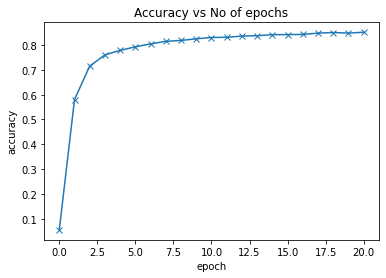

In [25]:
history = [result0] + history1 + history2 + history3 + history4

accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs No of epochs')
plt.show()

In [ ]:
# Softmax implementation using numpy

"""
Need to pass the numpy 1D vector
"""
def softmax(X):
  exp_term = np.exp(X)
  return exp_term/ np.sum(exp_term, axis=1).reshape(-1,1)